In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import pandas as pd

In [15]:
class KatoForceEncoder:
    
    def __init__(self, c):
        self.c = c
        self.dt = 0.001
        self.T = len(c)*self.dt
#         print(self.T)
        self.cm0 = 1e-5
        self.mlck0 = 1e-6
        self.K1 = 1e-5
        self.K2 = 1e-10 # 1e-9
        self.k1 = 25.0
        self.k2 = 5.0
        self.k3 = 2.5
        self.k4 = 0.5
        self.a = 0.2
        self.b = 0.05
        self.f = 0.01
        self.lamb = 0.05
        self.gamma1 = self.cm0 / self.K2
        self.gamma2 = self.mlck0 / self.K2
        self.emax = None
        self.m2max = None
        self.time = np.linspace(0, self.T, int(self.T/self.dt))
        
        
    def solve_e(self, c):
        
        bb = -1 - self.gamma1 / self.gamma2 - 1 / self.gamma2 * (1 + 1 / (c/self.K1)) ** 4
        cc = self.gamma1 / self.gamma2
        
        return (- bb - np.sqrt(bb**2 - 4 * cc)) / 2
        
    def rhs(self, y, t):
        
        if t < self.T: c = self.c[int(t/self.dt)]
        else: c = self.c[-1]
        
        e = self.solve_e(c)
        
        m1, m2, p = y

        dm1dt = - ((self.k1 + self.k3) * e + self.k2) * m1 - (self.k1 * e - self.k4) * m2 + self.k1 * e
        dm2dt = self.k3 * e * m1 - self.k4 * m2

#         m1 = 1 / (1 + self.k3 / self.k4 * e + 1 / (self.k1 / self.k2 * e))
#         m2 = 1 / (1 + 1 / (self.k3 / self.k4 * e) * (1 + 1 / (self.k3 / self.k4 * e)))
        
        
        dpdt = self.b * (p + self.f) * (m2/self.m2max - p) / self.lamb / (p + self.a)
        return [dm1dt, dm2dt, dpdt]
        
    def step(self):
        
        e0 = self.solve_e(self.c[0])
        m10 = 1 / (1 + self.k3 / self.k4 * e0 + 1 / (self.k1 / self.k2 * e0))
        m20 = 1 / (1 + 1 / (self.k3 / self.k4 * e0) * (1 + 1 / (self.k3 / self.k4 * e0)))
        
        e_test = self.solve_e(1e-6)
        print(e_test, 1 / (1 + 1 / (self.k3 / self.k4 * e_test) * (1 + 1 / (self.k3 / self.k4 * e_test))))

        if self.emax == None:
            self.emax = self.solve_e(np.Infinity)
            self.m2max = 1 / (1 + 1 / (self.k3 / self.k4 * self.emax) * (1 + 1 / (self.k3 / self.k4 * self.emax)))

        p0 = m20 / self.m2max
        
        y0 = [m10, m20, p0]
        sol = odeint(self.rhs, y0, self.time, hmax = 0.005)
        return sol

def calcium_trace(t):
    
    c = np.zeros(len(t))
    
    for j in range(len(t)):
        if 0 <= t[j] <= 0.5:
            c[j] = 1e-7 + (1e-6 - 1e-7) * t[j] / 0.5
        elif t[j] > 0.5:
            c[j] = 1e-7 + (1e-6 - 1e-7)  * np.exp( - 0.5 * (t[j] - 0.5))
    
    return c

### Alternative calcium traces
#     for j in range(len(t)):
#         if 0 <= t[j] <= 0.5:
#             c[j] = 1e-7 + (2e-6 - 1e-7) * t[j] / 0.5
#         elif t[j] > 0.5:
#             c[j] = 1e-6 + (2e-6 - 1e-6)  * np.exp( - 1.0 * (t[j] - 0.5))
    
#     return c

#     for j in range(len(t)):
#         if 0 <= t[j] <= 0.01:
#             c[j] = 1e-7 + (1e-5 - 1e-7) * t[j] / 0.01
#         elif t[j] > 0.5:
#             c[j] = 1e-7 + (1e-5 - 1e-7)  * np.exp( - 50 * (t[j] - 0.01))
    
#     return c
###

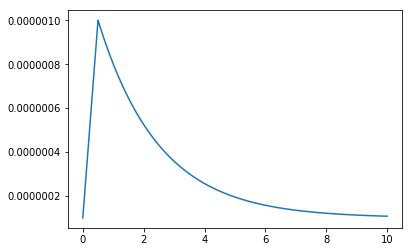

0.8619059421091881 0.7776725580253416


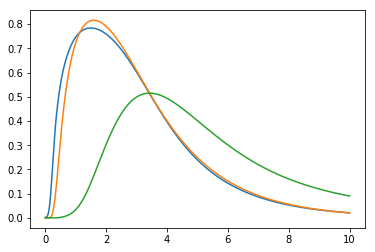

In [16]:
if __name__ == '__main__':
    t = np.linspace(0, 10.0, 10000)
    c = calcium_trace(t)
    plt.plot(t, c)
    plt.show()
    encoder = KatoForceEncoder(c)
    sol = encoder.step()
    plt.plot(t, 0.5 * sol[:, 0] + sol[:, 1])
    plt.plot(t, sol[:, 1]/encoder.m2max)
    plt.plot(t, sol[:, 2])

0.8619059421091881 0.7776725580253416


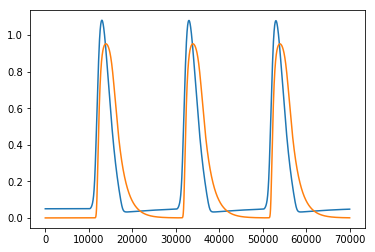

In [17]:
c = pd.read_csv('/home/hengji/Documents/hydra_calcium_model/cytosolic_calcium.txt', sep = ' ', header = None).values[:,1]
encoder = KatoForceEncoder(c/1e6) # uM -> M
sol = encoder.step()
plt.plot(c)
plt.plot(sol[:, 1]/encoder.m2max)
#     plt.plot(sol[:,2])

0.8619059421091881 0.7776725580253416


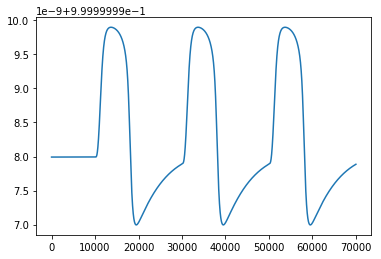

In [18]:
f_encoder = KatoForceEncoder(c)
force = f_encoder.step()[:,1]/f_encoder.m2max
plt.plot(force)